In [ ]:
!pip install imageio[ffmpeg] 
!pip install imageio[pyav]

In [34]:
import imageio
import numpy as np

In [64]:
import imageio as iio
import base64
import boto3
import json
import io
from PIL import Image

# CONFIGURATION
video_path = "videoblocks-aerial-view-people-walking-down-center-lane-grocery-shopping-by-produce-sec_ryyqlpbp3__9a31ad8ce3f137b6572eefb5e6255d81__P360.mp4"
# video_path = "videoblocks-liverpool-one-4_stxxmsz3jl__8c5529d1cba20914426b553c8c4cac59__P360.mp4"
model_id = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"  # e.g., "anthropic.claude-3-5-sonnet-20241022-v2:0"
region = "us-east-1"       # e.g., "us-east-1"

# 1. Extract frames from video using imageio
reader = iio.get_reader(video_path)
i = 0
frames = []
for frame in reader:
    i += 1
    img_pil = Image.fromarray(frame)
    buf = io.BytesIO()
    img_pil.save(buf, format="JPEG")
    img_bytes = buf.getvalue()
    frames.append(img_bytes)

print(f'Number of frame = {i}')





Number of frame = 241


In [65]:
iam = boto3.client('iam')

role = iam.get_role(RoleName='Bedrock-role')['Role']['Arn'] # please set IAM ro÷le

sts_client = boto3.client('sts')

assumed_role_object=sts_client.assume_role(
    RoleArn=role,
    RoleSessionName="AssumeRoleSession1"
)
credentials=assumed_role_object['Credentials']
bedrock_client = boto3.client('bedrock-runtime',
                            region_name=region,
                            aws_access_key_id=credentials["AccessKeyId"],
                            aws_secret_access_key=credentials["SecretAccessKey"],
                            aws_session_token=credentials["SessionToken"])

In [66]:
n = 20

indices = [int(i) for i in np.linspace(0, len(frames) - 1, n)]
selected_frames = [frames[i] for i in indices]
print(f'Number of frame = {len(selected_frames)}')

Number of frame = 20


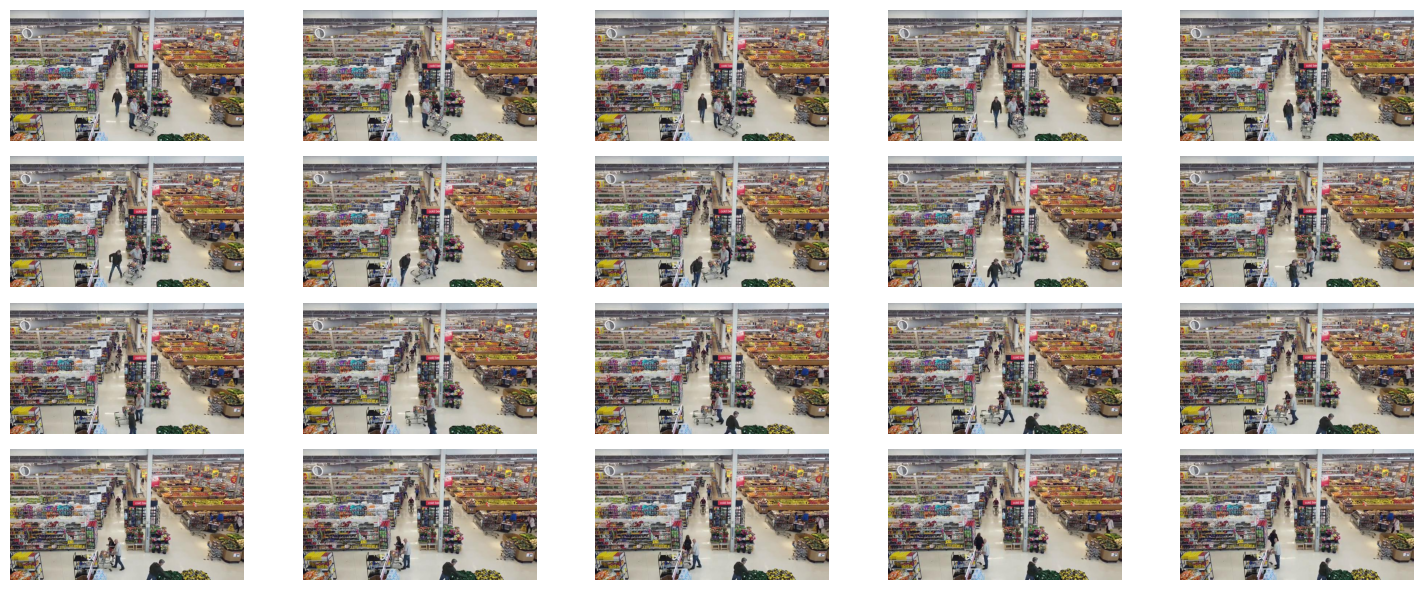

In [ ]:
import matplotlib.pyplot as plt

n_images = len(selected_frames)
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols  # Automatically compute rows

plt.figure(figsize=(15, 6))
for i, img_bytes in enumerate(selected_frames):
    img = Image.open(io.BytesIO(img_bytes))
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [68]:
# 2. Prepare content for Bedrock Claude 3
content = []
for img_bytes in selected_frames:
    content.append({
        "type": "image",
        "source": {
            "type": "base64",
            "media_type": "image/jpeg",
            "data": base64.b64encode(img_bytes).decode("utf-8")
        }
    })
# Add a text instruction
content.append({
    "type": "text",
    "text": """Analyze these frames from the video. Describe the scene.
    Identify anything abnormal on the people behavior.
    People count by different area."""
})

# 3. Send to Bedrock
bedrock = boto3.client("bedrock-runtime", region_name=region)
payload = {
    "anthropic_version": "bedrock-2023-05-31",
    "messages": [
        {
            "role": "user",
            "content": content
        }
    ],
    "max_tokens": 1024,
}

response = bedrock.invoke_model(
    modelId=model_id,
    body=json.dumps(payload),
    accept="application/json",
    contentType="application/json"
)

result = json.loads(response['body'].read())
print(result)

{'id': 'msg_bdrk_016rwuJ223f9s1BS7qWx6YCf', 'type': 'message', 'role': 'assistant', 'model': 'claude-3-5-sonnet-20241022', 'content': [{'type': 'text', 'text': 'This appears to be security camera footage from inside a retail store, likely a supermarket. Let me break down the key elements:\n\nLayout:\n- Left side: Packaged goods and general merchandise aisles\n- Center aisle: Main walkway with a "cold box" section\n- Right side: Produce and fresh goods section\n- Floral display near the center\n\nPeople Distribution:\n- Main aisle: 2-3 shoppers with carts\n- In the background: 2-3 people visible\n- Right side produce area: 1-2 shoppers\n- Total visible count: Approximately 6-8 people at any given time\n\nBehavior Analysis:\nThe most notable behavior is in the center of the frame, where shoppers appear to be lingering unusually long in one spot, having what seems to be an extended interaction. This is somewhat atypical for normal shopping behavior, where people typically move continuousl

In [69]:
print(result['content'][0]['text'])

This appears to be security camera footage from inside a retail store, likely a supermarket. Let me break down the key elements:

Layout:
- Left side: Packaged goods and general merchandise aisles
- Center aisle: Main walkway with a "cold box" section
- Right side: Produce and fresh goods section
- Floral display near the center

People Distribution:
- Main aisle: 2-3 shoppers with carts
- In the background: 2-3 people visible
- Right side produce area: 1-2 shoppers
- Total visible count: Approximately 6-8 people at any given time

Behavior Analysis:
The most notable behavior is in the center of the frame, where shoppers appear to be lingering unusually long in one spot, having what seems to be an extended interaction. This is somewhat atypical for normal shopping behavior, where people typically move continuously through aisles. The extended stationary positioning could indicate:
- A consultation or discussion
- Possible confusion about products
- An unusual interaction between shoppe